In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

c:\users\ulysse\appdata\local\programs\python\python39\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [31]:
def esprit_on_band(RI, fs, lowcut, highcut, poles, order=5, len_esprit=512*7, plot_result=False, number_of_max = 4, Nfft=100000) :
    """
    Cette fonction utilise l'algorithme ESPRIT sur une bande de fréquence particulière.
    Il calcul aussi la réponse en fréquence, et les amplitudes de cette réponses aux fréquence trouvées par ESPRIT.

    ## Inputs
    - `RI` : réponse impulsionnelle d'entrée
    - `fs` : fréquence d'échantillonnage
    - `lowcut` : fréquence de coupure basse du filtre à appliquer
    - `highcut` : fréquence de coupure haute du filtre à appliquer
    - `poles` : nombre de pôles calculés par ESPRIT
    - `order` : ordre du filtre butterworth utilisé
    - `len_esprit` : longueur de la portion ud signal donnée à ESPRIT
    - `plot_result` : trace la réponse en fréquence avec les fréquences trouvées par ESPRIT si `True`
    - `Nfft` : nombre de points pour la FFT

    ## Outputs
    - `freq_amp_sorted` : arrayLike, liste des fréquences trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    - `delta_amp_sorted` : arrayLike, liste des amortissements trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    """

    RI_filtered = mm.bandpass_filter(RI, lowcut, highcut, fs, order=order)
    fk, deltak = mm.ESPRIT(RI_filtered[:len_esprit], len_esprit//2, poles, return_pos=True)

    Y = np.fft.rfft(RI_filtered, Nfft)
    fy = np.fft.rfftfreq(Nfft,1/fs)

    #Calcul des amplitudes de la réponse en fréquences aux fréquences trouvées par ESPRIT
    amp = np.zeros(len(fk))
    for i in range(len(fk)) :
        fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
        amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
    freq_amp_sorted = fk[amp.argsort()[-number_of_max:][::-1]]*fs
    delta_amp_sorted = deltak[amp.argsort()[-number_of_max:][::-1]]
    amp_sorted = amp.argsort()[-number_of_max:][::-1]

    if plot_result :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)


        ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
        ax1.grid(which="both")
        #ax1.legend()
        ax1.set_xlabel("Fréquences $(Hz)$")
        ax1.set_ylabel("FFT $(dB)$")
        ax1.set_title(r"Réponse en fréquence filtrée, superposée à ESPRIT")
        ax1.set_xlim(30,2000)
        ylims = ax1.set_ylim()
        ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

        import matplotlib.ticker as mticker
        ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        fig.tight_layout()

        plt.show()

    return freq_amp_sorted, delta_amp_sorted, amp_sorted
    

In [32]:
def plot_frfs_mat(idx_mat) :
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)

    ax1.semilogx(deforme_Nta_Npos[idx_mat,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,0]["FRF"])),label="pos 1")
    ax1.semilogx(deforme_Nta_Npos[idx_mat,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,1]["FRF"])),label="pos 2")
    ax1.grid(which="both")
    ax1.set_title(f"Matériau : {deforme_Nta_Npos[idx_mat,0]['mat_table']}")
    ax1.set_ylabel("")
    ax1.set_xlabel("Fréquences $(Hz)$")
    ax1.legend()
    ax1.set_xlim(30,2000)
    ylims = ax1.set_ylim()

    import matplotlib.ticker as mticker
    ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())

    fig.tight_layout()

    plt.show()

# Analyse des tables : protocole

- Choisir un indice de matériau $i_m$ entre les 4 indices [0,1,2,3].
- Tracer la réponse en fréquence pour les 2 positions de frappe avec `plot_frfs_mat(idx_mat)` : l'idée est d'observer à la main où sont les pics en fréquences.
- Accéder aux réponses impulsionnelle avec `deforme_Nta_Npos[idx_mat, 0]`, `deforme_Nta_Npos[idx_mat, 1]`.
- Sélectionner à l'oeil une bande de fréquence où il y a un ou plusieurs pics, et utiliser `esprit_on_band()` pour appliquer esprit sur cette bande de fréquence.
- Sélectionner les fréquences cohérentes avec les pics, et les amortissements, à noter quelque part.
- Faire cela pour une vingtaine de mode par plaque.

In [75]:
idx_mat = 0 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

print(dico_pos1["mat_table"]) #C'est donc le plexi

Medium_1


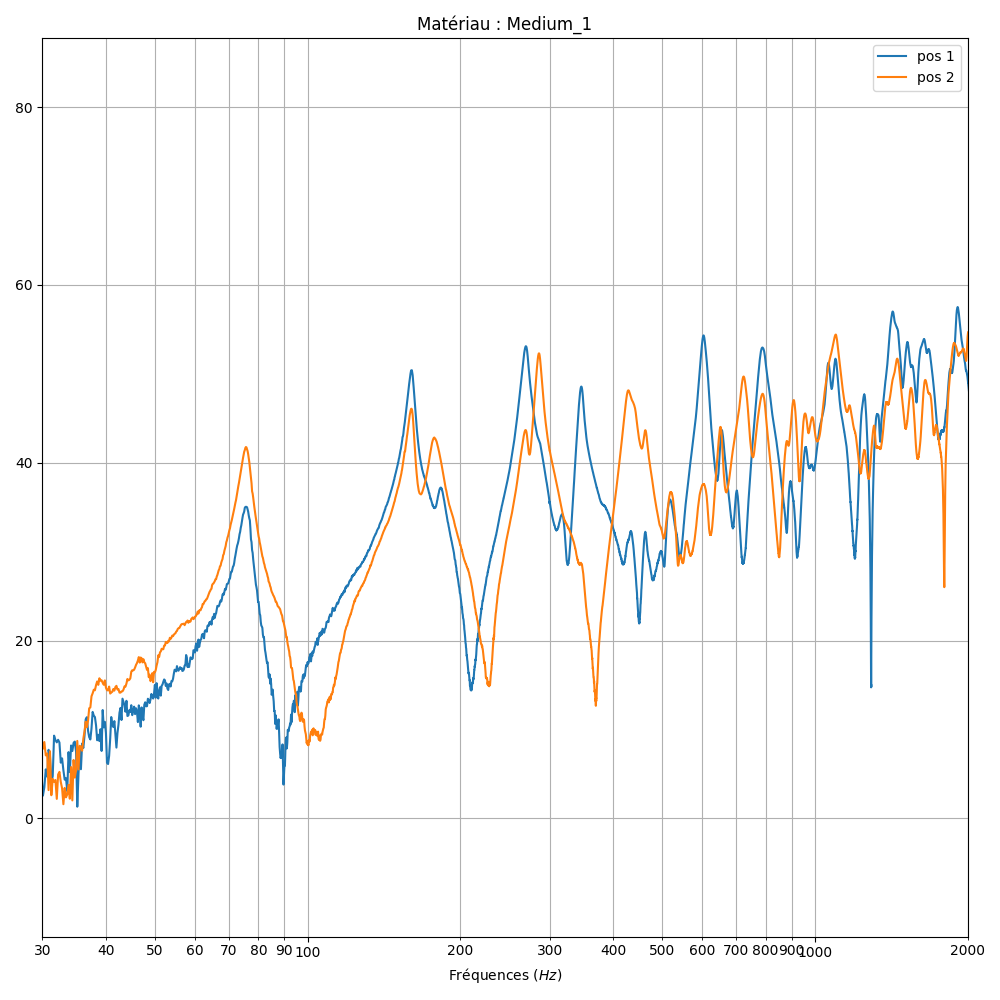

In [76]:
plot_frfs_mat(idx_mat)

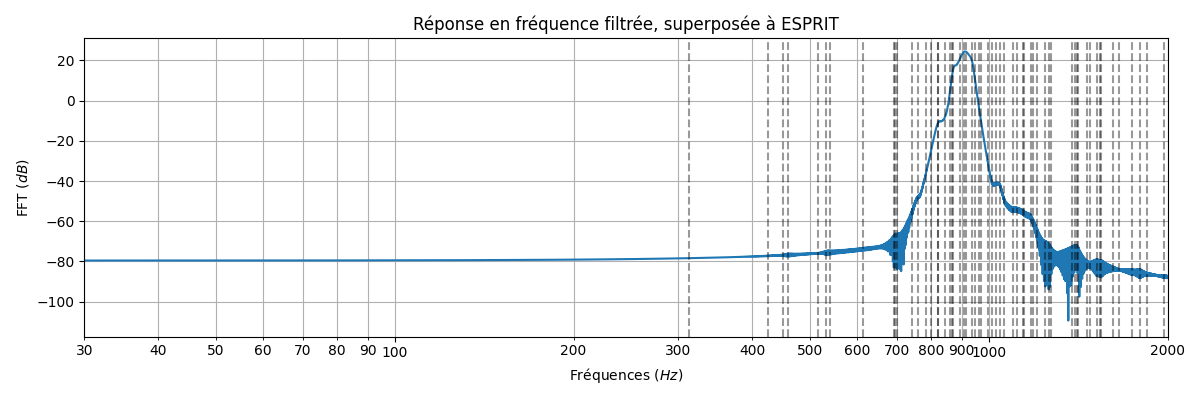

In [72]:
fk, deltak, amp = esprit_on_band(dico_pos2["RI"], dico_pos1["fs"], lowcut=870, highcut=940, poles=300, order=200, plot_result=True, len_esprit=512*10, number_of_max=10)
# print(fk)
# print(deltak)

In [73]:
fk

array([915.23352949, 907.18744981, 893.63292559, 938.43914863,
       871.89665405, 868.27080842, 948.75370708, 860.67984272,
       962.77518717, 844.08998442])

In [74]:
deltak

array([-0.00254156, -0.0021184 , -0.00135594, -0.00133878, -0.00097634,
       -0.0455176 , -0.00451349, -0.00127746,  0.00032549, -0.00145694])

In [65]:
import pandas as pd

modal_analysis = {
    "table" : dico_pos1["mat_table"],
    "freq" : np.array([106.97717034, 164.90739819, 189.34747316, 265.9351928, 413.26057931, 425.57839152, 460.04801994, 533.50668071, 604.37383295, 694.37280608, 759.73928757, 817.61882733, 870.98284749,915.9211783]),
    "xi" : np.array([-0.00049113, -0.00157001, -0.00049113, -0.00049113, -1.30689117e-03, -0.00197893, -0.0010245, -8.31450033e-04, -1.22539750e-03, -1.16633567e-03, -1.15342785e-03, -0.00172967, -0.00121822, -0.00265855]),
}

modal_analysis["ratios"] = modal_analysis["freq"]/modal_analysis["freq"][0]

modal_analysis = pd.DataFrame(modal_analysis).T
modal_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12
table,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2,Medium_2
freq,106.97717,164.907398,189.347473,265.935193,413.260579,425.578392,460.04802,533.506681,604.373833,694.372806,759.739288,817.618827,915.921178
xi,-0.000491,-0.00157,-0.000491,-0.000491,-0.001307,-0.001979,-0.001025,-0.000831,-0.001225,-0.001166,-0.001153,-0.00173,-0.002659
ratios,1.0,1.54152,1.76998,2.485906,3.863073,3.978217,4.300432,4.987108,5.649559,6.49085,7.101882,7.642928,8.561838
